# Entity type clustering

In [11]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, SpectralClustering, AgglomerativeClustering
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, SpectralEmbedding
from gensim.models import Word2Vec, KeyedVectors
from  gensim import downloader
import math
import pickle

from tqdm import tqdm
from collections import Counter

import dist_util as util

In [2]:
random_state = 4012

# Avoid downloading / loading the whole Word2Vec Google News 300 model
quick = True

if quick:
    entities = ['genre', 'song', 'writer', 'university', 'javascript', 'enzyme', 'award', 'chemical', 'person', 'event', 'conference', 'protein', 'magazine', 'task', 'galaxy', 'journal', 'album', 'researcher', 'discipline', 'band', 'book', 'country', 'election', 'algorithm', 'organization', 'location', 'poem', 'product', 'metrics', 'miscellaneous', 'musician', 'field', 'politician', 'coalition', 'theory', 'violin', 'scientist']
    with open("embs.pkl", "rb") as f:
        embeddings = pickle.load(f)

In [3]:
if quick == False:
    # Labels (Manual copy from .env file)
    entities_orig = "academicjournal album algorithm astronomicalobject award band book chemicalcompound chemicalelement conference country discipline election enzyme event field literarygenre location magazine metrics misc musicalartist musicalinstrument musicgenre organisation person poem politicalparty politician product programlang protein researcher scientist song task theory university writer"
    entities_orig = entities_orig.split()

    # Load Word2Vec embeddings - First time download: ~1.6 GB
    print("Loading pretrained Word2Vec model, this may take a while.")
    w2v = downloader.load("word2vec-google-news-300")

    # Check which words are not in Word2Vec model
    missing = util.find_missing(w2v, entities_orig)
    print(f"These entities are not in the model:\n{missing}")

In [5]:
if quick == False:
    # Manual correction
    substitute = {"musicalartist": "musician", "organisation": "organization", "politicalparty": "coalition", "academicjournal": "journal", "chemicalcompound": "chemical", "chemicalelement": "chemical", "astronomicalobject": "galaxy", "musicgenre": "genre", "literarygenre": "genre", "programlang": "javascript", "musicalinstrument": "violin", "misc": "miscellaneous"}
    entities = set()
    for entity in entities_orig:
        if entity in substitute:
            entities.add(substitute[entity])
        else:
            entities.add(entity)

    entities = list(entities)

    still_missing = util.find_missing(w2v, entities)
    if len(still_missing) > 0:
        print("These entities are not in the model:")
        print(still_missing)
    else:
        print("All entities are in the model. Final list:")
        print(entities)
        print("Loading embeddings for them.")
        embeddings = w2v[entities]

In [6]:
# Dimensionality Reduction
pca2 = PCA(n_components=2, svd_solver="full") # random state not needed for "full" solver
pca3 = PCA(n_components=15, svd_solver="full") ######################
pca2 = pca2.fit_transform(embeddings)
pca3 = pca3.fit_transform(embeddings)

mds2 = MDS(n_components=2, random_state=random_state)
mds3 = MDS(n_components=10, random_state=random_state) ###################
mds2 = mds2.fit_transform(embeddings)
mds3 = mds3.fit_transform(embeddings)

se2 = SpectralEmbedding(n_components=10, random_state=random_state) ###################
se2 = se2.fit_transform(embeddings)

/home/davidsule/anaconda3/envs/2yp/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/davidsule/anaconda3/envs/2yp/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [17]:
# K-Means
km5 = KMeans(n_clusters=5, random_state=random_state, n_init=100)
km5 = km5.fit_predict(se2)

a = util.get_categories(km5, entities)
for i, l in a.items():
    print(f"{i}:\t{l}")

0:	['coalition', 'product', 'javascript', 'event', 'field', 'university', 'algorithm', 'conference', 'election', 'task', 'country', 'metrics', 'award', 'organization', 'person', 'discipline', 'location', 'galaxy', 'miscellaneous']
3:	['enzyme', 'protein', 'chemical']
1:	['book', 'theory', 'poem']
2:	['journal', 'magazine']
4:	['song', 'writer', 'band', 'musician', 'politician', 'album', 'scientist', 'genre', 'violin', 'researcher']


/home/davidsule/anaconda3/envs/2yp/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [124]:
f = open("kmeans.txt", "w")

# n_clusters = range(5, 10)
# dimred_methods = ["pca", "mds", "se"]
# n_components = [3,4,5,8,12,16,20,30,50,90,150,220,300]

# PROMISING
# K-MEANS
# 5 mds 3-5
# 6 mds 3-8
# 7 mds 3-8
# 7 se 5-8
# 8 mds 5-12
# 8 se 3-12
# 9 mds 3-12
# 9 se 3-12

n_clusters = range(5, 10)
dimred_methods = ["mds", "se"]
n_components = [2,3,4,5,6,7,8,10,12]

for n in tqdm(n_clusters):
    for dimred in dimred_methods:
        for comp in n_components:
            if dimred == "pca":
                if comp > 37:
                    continue
                d = PCA(n_components=comp, svd_solver="full")
            elif dimred == "mds":
                d = MDS(n_components=comp, random_state=random_state)
            else:
                if comp > 37:
                    continue
                d = SpectralEmbedding(n_components=comp, random_state=random_state)
            d = d.fit_transform(embeddings)
            km = KMeans(n_clusters=n, random_state=random_state, n_init=10)
            km = km.fit_predict(d)
            cat = util.get_categories(km, entities)
            f.write(f"\n{str(n)}\t{dimred}\t{comp}\n")
            for i, l in cat.items():
                f.write(f"{i}:\t{l}\n")
f.close()

  0%|          | 0/5 [00:00<?, ?it/s]/home/davidsule/anaconda3/envs/2yp/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/davidsule/anaconda3/envs/2yp/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/davidsule/anaconda3/envs/2yp/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/davidsule/anaconda3/envs/2yp/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value 

In [87]:
f = open("affinity.txt", "w")

damping = [0.5, 0.7]
dimred_methods = ["pca", "mds", "se"]
n_components = [3,4,5,6,8,12,16,20,30,50,90,150,220,300]

for damp in tqdm(damping):
    for dimred in dimred_methods:
        for comp in n_components:
            if dimred == "pca":
                if comp > 37:
                    continue
                d = PCA(n_components=comp, svd_solver="full")
            elif dimred == "mds":
                d = MDS(n_components=comp, random_state=random_state)
            else:
                if comp > 37:
                    continue
                d = SpectralEmbedding(n_components=comp, random_state=random_state)
            d = d.fit_transform(embeddings)
            km = AffinityPropagation(damping=damp, random_state=random_state)
            km = km.fit_predict(d)
            cat = util.get_categories(km, entities)
            f.write(f"\n{str(damp)}\t{dimred}\t{comp}\n")
            for i, l in cat.items():
                f.write(f"{i}:\t{l}\n")
f.close()

  0%|          | 0/2 [00:00<?, ?it/s]/home/davidsule/anaconda3/envs/2yp/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/davidsule/anaconda3/envs/2yp/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/davidsule/anaconda3/envs/2yp/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/davidsule/anaconda3/envs/2yp/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value 

In [123]:
d = MDS(n_components=6, random_state=random_state)
d = d.fit_transform(embeddings)
db = AgglomerativeClustering(n_clusters=6, linkage="ward")
db = db.fit_predict(d)
a = util.get_categories(db, entities)
for i, l in a.items():
    print(f"{i}:\t{l}")

0:	['genre', 'javascript', 'person', 'algorithm', 'location', 'product', 'miscellaneous']
3:	['song', 'album', 'band', 'poem', 'musician', 'violin']
5:	['writer', 'researcher', 'politician', 'scientist']
2:	['university', 'chemical', 'event', 'conference', 'task', 'galaxy', 'country', 'election', 'organization', 'field', 'coalition']
4:	['enzyme', 'protein']
1:	['award', 'magazine', 'journal', 'discipline', 'book', 'metrics', 'theory']


/home/davidsule/anaconda3/envs/2yp/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [16]:
with open("kmeans100.txt") as f:
    read = True
    k = []
    dimr = []
    dim = []
    for line in f.readlines():
        if read:
            l = line.split()
            k.append(l[0])
            dimr.append(l[1])
            dim.append(l[2])
            read = False
        if line == "\n":
            read = True

# k = Counter(k)
# dimr = Counter(dimr)
# dim = Counter(dim)
print(k)
print(dimr)
print(dim)

a = pd.DataFrame({"k": k, "dimr": dimr, "dim": dim})
a

['5', '5', '5', '6', '6', '6', '6', '6', '7', '7', '7', '7', '7', '8', '8', '8', '8', '8', '8', '8', '9', '9', '9', '9', '9']
['mds', 'mds', 'mds', 'mds', 'mds', 'mds', 'mds', 'se', 'mds', 'mds', 'mds', 'se', 'se', 'mds', 'mds', 'mds', 'se', 'se', 'se', 'se', 'mds', 'mds', 'se', 'se', 'se']
['3', '4', '6', '2', '4', '6', '8', '6', '4', '6', '7', '5', '6', '3', '6', '8', '5', '6', '7', '8', '4', '7', '5', '6', '8']


,k,dimr,dim
0,5,mds,3
1,5,mds,4
2,5,mds,6
3,6,mds,2
4,6,mds,4
5,6,mds,6
6,6,mds,8
7,6,se,6
8,7,mds,4
9,7,mds,6


/home/davidsule/anaconda3/envs/2yp/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


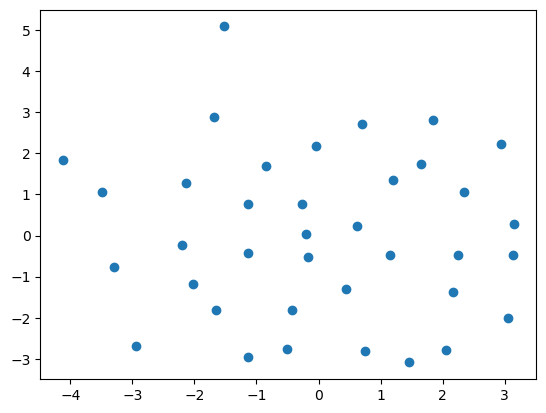

In [13]:
import matplotlib.pyplot as plt
r = 5
mds2 = MDS(n_components=2, random_state=r)
mds2 = mds2.fit_transform(embeddings)
plt.scatter(mds2[:, 0], mds2[:, 1])

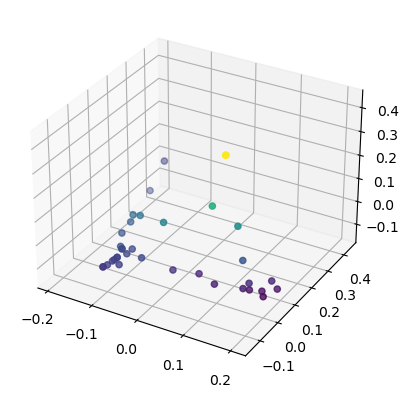

In [25]:
fig = plt.figure()
r = 4012
se2 = SpectralEmbedding(n_components=3, random_state=r) ###################
se2 = se2.fit_transform(embeddings)
ax = fig.add_subplot(projection='3d')
ax.scatter(se2[:, 0], se2[:, 1], se2[:, 2], c=se2[:, 2])